# Prediction of Obesity Levels

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
from scipy import stats
import seaborn as sns
from dython.nominal import conditional_entropy
from collections import Counter

In [2]:
original_df=pd.read_csv('ObesityDataSet.csv', usecols=['Gender', 'Age', 'Height', 'Weight', \
    'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', \
    'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'])
df=original_df.copy()
#replace index names
df=df.rename(index=str, columns={'family_history_with_overweight':'fam_hist', \
    'FAVC':'high_cal_foods', 'FCVC':'veg', 'NCP':'num_main_meals', \
    'CAEC':'food_between_meals', 'CH2O':'daily_water', 'CALC':'alcohol', \
    'SCC':'cal_consumption_monitoring', 'FAF':'physical_activity', \
    'TUE':'time_using_tech_devices', 'MTRANS':'transportation', \
    'SMOKE':'nicotine', 'NObeyesdad':'obesity_lvl'})

df=df.drop(df.index[498:])

In [3]:
#calculate mass body index from weight and height
df['BMI']=np.round(df.Weight/(df.Height*df.Height), 3)

In [4]:
df.shape

(498, 18)

In [5]:
#check columns
df.head()

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,daily_water,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl,BMI
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.387
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.238
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.765
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.852
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.342


The last 77% of rows contain synthetic data created via the Weka tool and SMOTE filter so they were dropped. The index names were changed to be identified more easily and BMI was calculated.

In [6]:
#check for missing values
df.isna().any()

Gender                        False
Age                           False
Height                        False
Weight                        False
fam_hist                      False
high_cal_foods                False
veg                           False
num_main_meals                False
food_between_meals            False
nicotine                      False
daily_water                   False
cal_consumption_monitoring    False
physical_activity             False
time_using_tech_devices       False
alcohol                       False
transportation                False
obesity_lvl                   False
BMI                           False
dtype: bool

In [7]:
#check all data types
df.dtypes

Gender                         object
Age                           float64
Height                        float64
Weight                        float64
fam_hist                       object
high_cal_foods                 object
veg                           float64
num_main_meals                float64
food_between_meals             object
nicotine                       object
daily_water                   float64
cal_consumption_monitoring     object
physical_activity             float64
time_using_tech_devices       float64
alcohol                        object
transportation                 object
obesity_lvl                    object
BMI                           float64
dtype: object

**Age**, **height**, **weight**, and **BMI** are metric variables. 


In [8]:
col1=['Age', 'Height', 'Weight', 'BMI']
for col in col1:
    print(df[col].describe())

count    498.000000
mean      23.146586
std        6.721583
min       14.000000
25%       19.000000
50%       21.000000
75%       24.000000
max       61.000000
Name: Age, dtype: float64
count    498.000000
mean       1.686386
std        0.097653
min        1.450000
25%        1.612500
50%        1.680000
75%        1.750000
max        1.980000
Name: Height, dtype: float64
count    498.000000
mean      69.569880
std       17.013226
min       39.000000
25%       58.000000
50%       67.000000
75%       80.000000
max      173.000000
Name: Weight, dtype: float64
count    498.000000
mean      24.313544
std        4.772286
min       13.292000
25%       20.999000
50%       23.688500
75%       26.673000
max       49.472000
Name: BMI, dtype: float64


There are no missing values. The age range is from 14 to 61, but the data seems to mostly consist of young adults (mean=23).

Columns **veg**, **num_main_meals**, **daily_water**, **physical_activity**, and **time_using_tech_devices** contain floats of ordinal values, some of which were interval values before conversion by the original authors of the dataset. These ordinal values correspond to levels of consumption or activity.

In [9]:
col2=['veg', 'num_main_meals', 'daily_water', 'physical_activity', \
      'time_using_tech_devices']
for col in col2:
    print(df[col].value_counts())

2.0    272
3.0    194
1.0     32
Name: veg, dtype: int64
3.0    344
1.0    108
4.0     46
Name: num_main_meals, dtype: int64
2.0    266
1.0    135
3.0     97
Name: daily_water, dtype: int64
0.0    162
1.0    158
2.0    113
3.0     65
Name: physical_activity, dtype: int64
0.0    243
1.0    181
2.0     74
Name: time_using_tech_devices, dtype: int64


**veg**: "Do you usually eat vegetables?" -> "Never", "Sometimes", and "Always".

**num_main_meals**: "How many main meals do you have daily?" -> "Between 1 and 2", "Three", "More than Three"

**daily_water**: "How much water do you drink daily?" -> "Less than 1L", "Between 1 and 2L", "More than 2L"

**physical_activity**: "How often do you have physical activity?" -> "None", "1 or 2 days", "2 or 4 days", "4 or 5 days" (assuming per week) 

**time_using_tech_devices**: "How much time do you use technological devices such as cell phones, video games, television, computers, etc.." -> "0 to 2 hours", "3 to 5 hours", "more than 5 hours"






Columns **food_between_meals** and **alcohol** contain ordinal survey answers which are not translated to numerical values.  

In [10]:
col3=['food_between_meals', 'alcohol']
for col in col3:
    print(df[col].value_counts())

Sometimes     289
Frequently    136
Always         53
no             20
Name: food_between_meals, dtype: int64
Sometimes     273
no            179
Frequently     45
Always          1
Name: alcohol, dtype: int64


Only one person responded 'Always' to alcohol consumption. We should remove this data and others with less than 20 value counts.

In [11]:
df[df['alcohol']=='Always']
df=df.drop(df[df['alcohol']=='Always'].index)

**Gender**, **fam_hist**, **high_cal_foods**, **cal_consumption_monitoring**, **nicotine**, and **transportation** seem to be nominal data with no ordering or direction, although transportation could potentially converted into levels of exercise. 

In [12]:
col4=['Gender', 'fam_hist', 'high_cal_foods', 'cal_consumption_monitoring', \
      'nicotine', 'transportation']
for col in col4:
    print(df[col].value_counts())

Male      270
Female    227
Name: Gender, dtype: int64
yes    299
no     198
Name: fam_hist, dtype: int64
yes    347
no     150
Name: high_cal_foods, dtype: int64
no     442
yes     55
Name: cal_consumption_monitoring, dtype: int64
no     465
yes     32
Name: nicotine, dtype: int64
Public_Transportation    326
Automobile                99
Walking                   54
Motorbike                 11
Bike                       7
Name: transportation, dtype: int64


In [13]:
#drop less than 20 value counts
df=df.drop(df[df['transportation']=='Motorbike'].index)
df=df.drop(df[df['transportation']=='Bike'].index)

The variable we want to compare, **obesity_lvl** is an ordinal variable which contain levels corresponding to the **BMI** as defined by the CDC. We can later choose the dependent variable to be qualitative (obesity level) or quantitative (BMI). 

Here we plot a histogram for all datapoints showing the BMI and obesity level range.

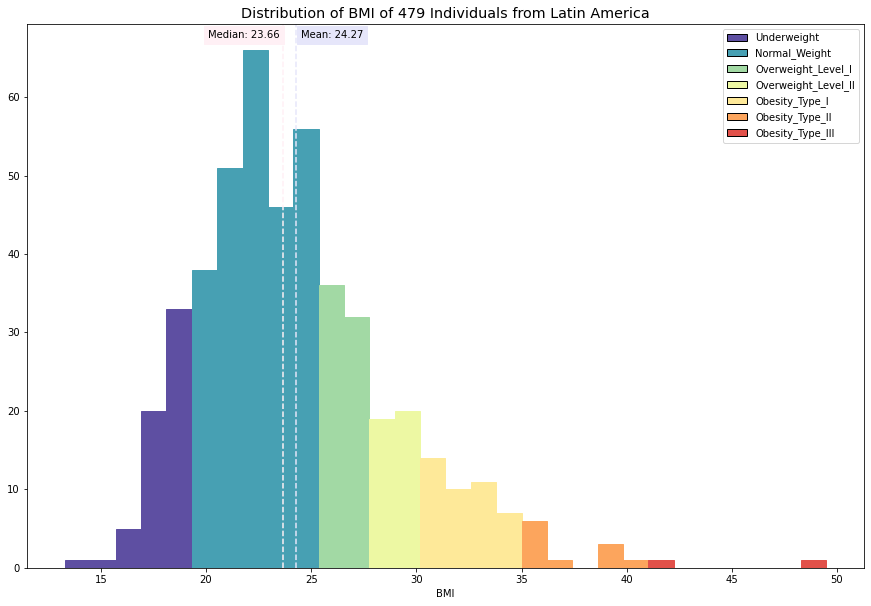

In [14]:
plt.figure(figsize=(15,10))
n, bins, patches=plt.hist(df.BMI,30)
bounds=[18.5,25.0,27.0,30.0,35.0,40.0]
cmap=plt.get_cmap('Spectral')

for bar in patches:
    x, y = bar.get_xy()
    w = bar.get_width()
    if x < bounds[0]:
        bar.set_color(cmap(1.0))
    elif x < bounds[1] and x >= bounds[0]:
        bar.set_color(cmap(6/7))
    elif x < bounds[2] and x >= bounds[1]:
        bar.set_color(cmap(5/7))
    elif x < bounds[3] and x >= bounds[2]:
        bar.set_color(cmap(4/7))
    elif x < bounds[4] and x >= bounds[3]:
        bar.set_color(cmap(3/7))
    elif x < bounds[5] and x >= bounds[4]:
        bar.set_color(cmap(2/7))
    elif x >= bounds[5]:
        bar.set_color(cmap(1/7))
        
handles=[matplotlib.patches.Rectangle((0,0),1,1,color=c,ec='k') for c in [cmap(i/7) for i in range(7,0,-1)]]
labels=[lvl for lvl in df.obesity_lvl.unique()]
labels.pop(4)
labels.insert(0, 'Underweight')
df.obesity_lvl=df.obesity_lvl.replace('Insufficient_Weight', 'Underweight')
plt.legend(handles,labels)
plt.xlabel('BMI')

min_ylim, max_ylim=plt.ylim()
plt.axvline(df.BMI.mean(), linestyle='dashed', color='lavender')
plt.text(df.BMI.mean()*1.01, max_ylim*0.975, 'Mean: '+str(round(df.BMI.mean(), 2)), fontsize='medium', backgroundcolor='lavender')

plt.axvline(df.BMI.median(), linestyle='dashed', color='lavenderblush')
plt.text(df.BMI.median()*0.85, max_ylim*0.975, 'Median: '+str(round(df.BMI.median(), 2)), fontsize='medium', backgroundcolor='lavenderblush')
plt.title('Distribution of BMI of '+str(len(df))+' Individuals from Latin America', fontsize='x-large')

plt.show()


We have an abundance of people with normal weight (probably because the dataset was based on an internet survey and therefore targetted the younger population. Perhaps this dataset is not an accurate representation of the whole population in Latin America.

We can choose frequency stacked barplots and boxplots to visualize group differences.

In [15]:
#print min, max, counts for obesity levels

ob1=df[df.obesity_lvl=='Overweight_Level_I']
ob2=df[df.obesity_lvl=='Overweight_Level_II']
print([[df[df.obesity_lvl==lvl].min().BMI, df[df.obesity_lvl==lvl].max().BMI, \
        df[df.obesity_lvl==lvl].BMI.count(), lvl] for lvl in labels])


[[13.292, 18.424, 34, 'Underweight'], [18.491, 24.913, 276, 'Normal_Weight'], [25.076, 26.892, 55, 'Overweight_Level_I'], [26.99, 29.938, 57, 'Overweight_Level_II'], [30.11, 34.894, 44, 'Obesity_Type_I'], [35.003, 39.258, 10, 'Obesity_Type_II'], [40.645, 49.472, 3, 'Obesity_Type_III']]


In [16]:
def barplots(column):
    underweight=[]
    normalweight=[]
    overweight=[]
    obese=[]
    
    for category in sorted(df[column].unique()):
        n_category=len(df[df[column]==category])
        n_underweight=len(df[(df[column]==category) & (df.obesity_lvl=='Underweight')])
        n_normalweight=len(df[(df[column]==category) & (df.obesity_lvl=='Normal_Weight')])
        n_overweight=len(df[(df[column]==category) & ((df.obesity_lvl=='Overweight_Level_I') \
                            | (df.obesity_lvl=='Overweight_Level_II'))])
        n_obese=len(df[(df[column]==category) & ((df.obesity_lvl=='Obesity_Type_I') \
                            | (df.obesity_lvl=='Obesity_Type_II') | (df.obesity_lvl=='Obesity_Type_III'))])
        
        underweight.append(n_underweight/n_category)
        normalweight.append(n_normalweight/n_category)
        overweight.append(n_overweight/n_category)
        obese.append(n_obese/n_category)

        
    underweight=np.array(underweight)
    normalweight=np.array(normalweight)
    overweight=np.array(overweight)
    obese=np.array(obese)
    
    width=0.2
    fig, ax = plt.subplots()
    x_labels=['Underweight', 'Normal weight', 'Overweight']
    bar1=ax.bar(sorted(df[column].unique()), normalweight, label='Normal Weight', width=width, color=cmap(6/7))
    bar2=ax.bar(sorted(df[column].unique()), underweight, label='Underweight', bottom=normalweight, width=width, color=cmap(1.0))
    bar3=ax.bar(sorted(df[column].unique()), overweight, label='Overweight', bottom=normalweight+underweight, width=width, color=cmap(4/7))
    bar4=ax.bar(sorted(df[column].unique()), obese, label='Obese', bottom=overweight+normalweight+underweight, width=width, color=cmap(1/7))
    ax.set_ylabel('Relative Frequency')
    ax.set_title(column + ' by Obesity Group')
    ax.legend(fontsize=10)
    
    ax.bar_label(bar1, labels=np.round(normalweight, 3), label_type='center')
    ax.bar_label(bar2, labels=np.round(underweight, 3), label_type='center')
    ax.bar_label(bar3, labels=np.round(overweight, 3), label_type='center')
    ax.bar_label(bar4, labels=np.round(obese, 3), label_type='center')
    plt.show()


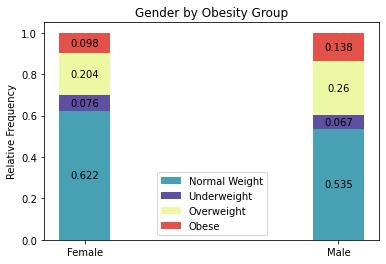

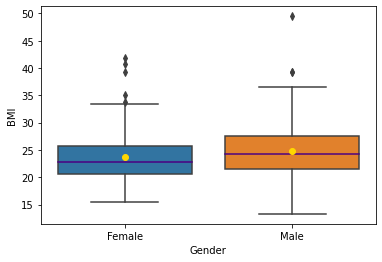

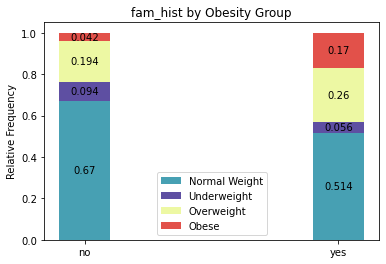

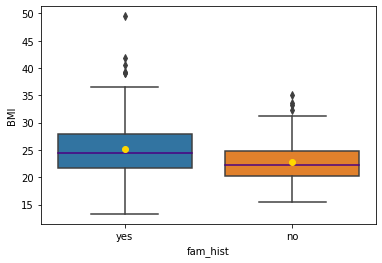

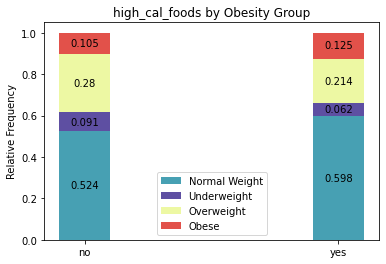

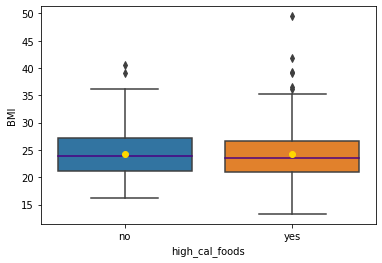

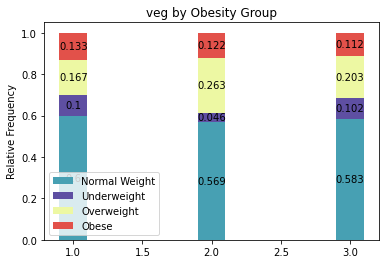

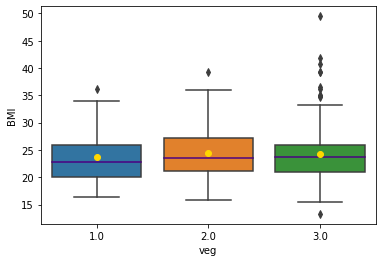

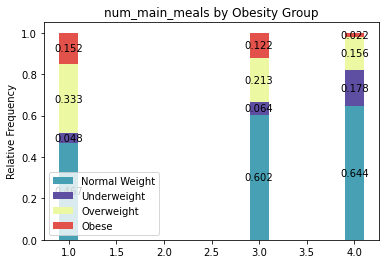

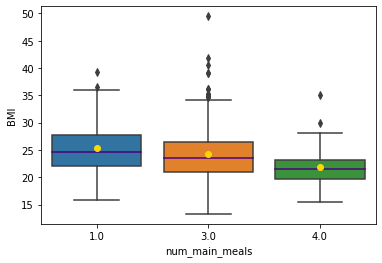

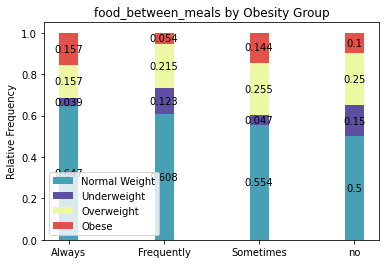

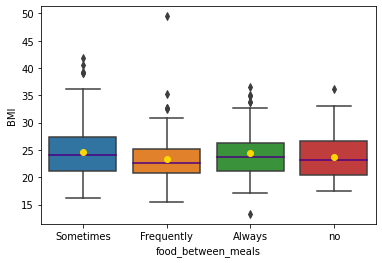

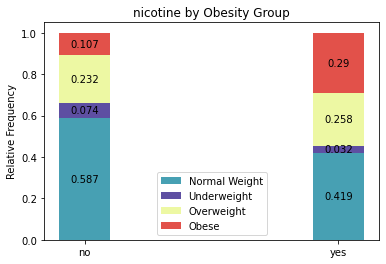

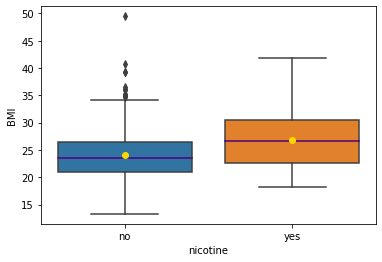

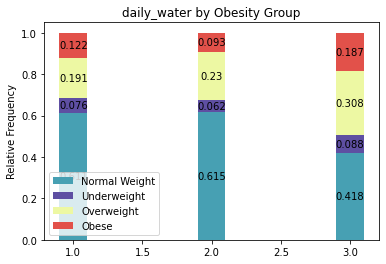

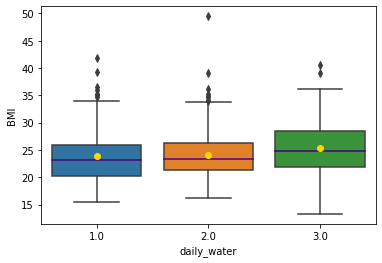

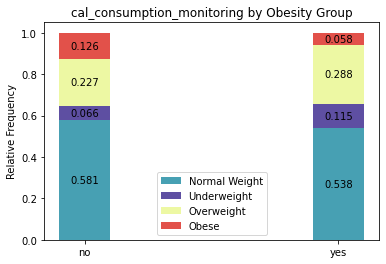

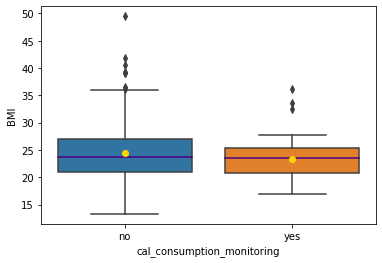

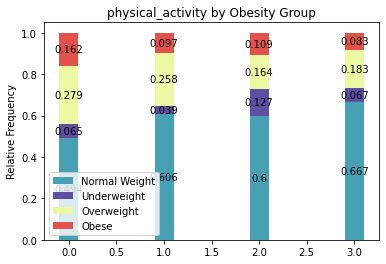

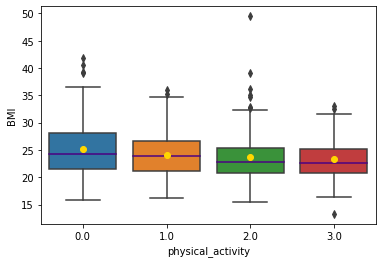

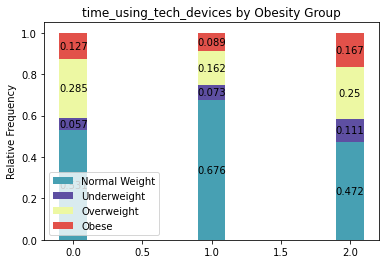

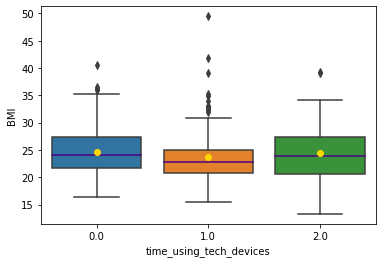

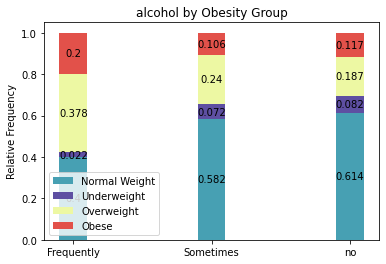

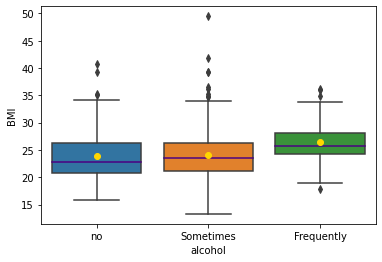

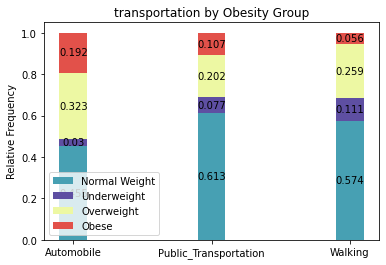

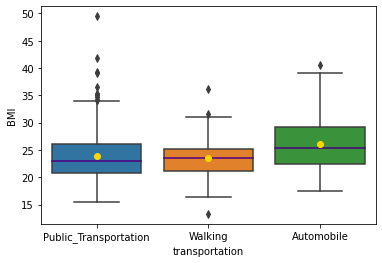

In [17]:
#plot with function
for col in df.columns:
    if col not in ('obesity_lvl', 'Height', 'Weight', 'Age', 'BMI'):
        barplots(col)
        sns.boxplot(x=col, y='BMI', data=df, showmeans=True, medianprops={'color':'indigo'}, meanprops={'marker':'o','markerfacecolor':'gold','markeredgecolor':'gold'})
        plt.show()


There are visible group mean differences in **Gender**, **fam_hist**, **nicotine**, **num_main_meals**, **physical_activity**, **alcohol**, and **public transportation**.

Females have a lower percentage of obesity but a higher count of values higher than the interquartile range. 

People with no family history of obesity have less of a weight overall, regardless of what weight group they are in. 

Eating high caloric foods surprisingly does not correspond to more weight, perhaps due to the potential correlation of high caloric food consumption to physical activity. Those who are more physically active tend to be less obese. 

Higher vegetable consumption does not necessarily lead to less obesity but has a higher count of values outside of the interquartile range. 

The higher the number of main meals, the lesser the weight, presumably due to that people who eat more frequently eat less portions. People who eat 3 meals per day have a lesser mean and median than those who eat lesser meals but are more spread out in terms of BMI. 

Having more food between meals doesn't seem to affect the mean and median much but also is attributed to more spread. 

Those who consume more nicotine or alcohol are more obese. Those who consume more water are more obese. Perhaps there is no correlation between water consumption and physical activity. 

Monitoring caloric consumption does not seem to necessarily change the mean and median but decrease the spread. 

People who use technological devices for 3 to 5 hours daily are least obese but some are situated outside of the IQR. 

People who use the car as their primary mode of transportation are most obese but ones who use public transportation have many outliers higher than the IQR.



Overall, the means and medians don't seem to differ much, but there seem to be differences within features in affect the overall distribution by pushing out the mean to the right. 

We can visualize the correlation between columns using the Pearson's correlation coefficient. First we convert the ordinal categories into numerical levels:

In [18]:
for col in col3:
    df[col]=df[col].map({'no':0., 'Sometimes':1., 'Frequently':2., 'Always':3.})
df.head()

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,daily_water,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl,BMI
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,1.0,no,2.0,no,0.0,1.0,0.0,Public_Transportation,Normal_Weight,24.387
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,1.0,yes,3.0,yes,3.0,0.0,1.0,Public_Transportation,Normal_Weight,24.238
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,1.0,no,2.0,no,2.0,1.0,2.0,Public_Transportation,Normal_Weight,23.765
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,1.0,no,2.0,no,2.0,0.0,2.0,Walking,Overweight_Level_I,26.852
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,1.0,no,2.0,no,0.0,0.0,1.0,Public_Transportation,Overweight_Level_II,28.342


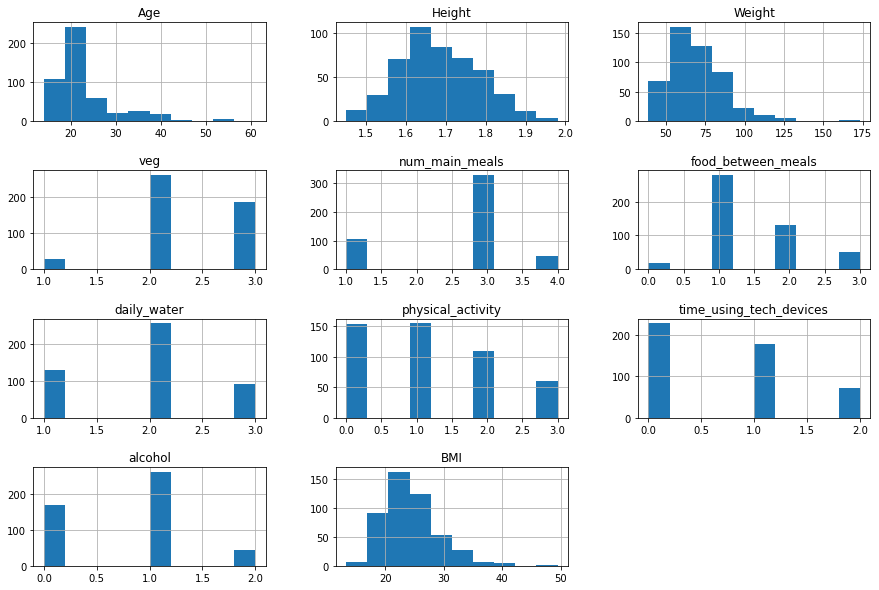

In [19]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

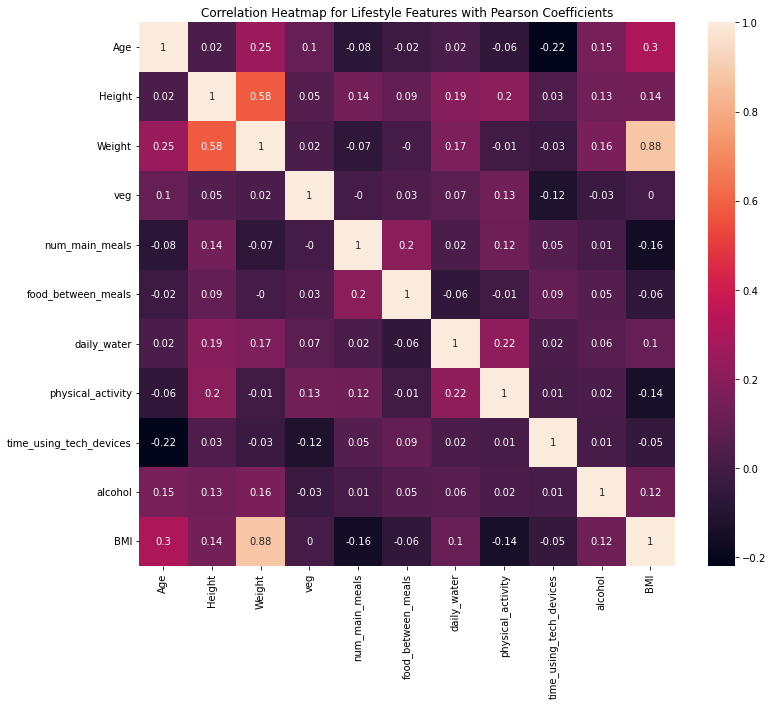

In [20]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(round(df.corr(), 2), annot=True)
ax.set_title('Correlation Heatmap for Lifestyle Features with Pearson Coefficients');


**BMI** and **weight** are highly correlated (r=0.88), as BMI is a function of weight. **Height** and **weight** are highly correlated (r=0.58). BMI is also a function of height but is less correlated with only a Pearson coefficient of 0.14. **Age** and **BMI** are moderately correlated (r=0.3). 

other slight correlations worth noting (r~0.2):
- **Age** and **weight** (r=0.25)
- **Age** and **time_using_tech_devices** (r=-0.22)
- **Height** and **daily_water** (r=0.19)
- **Height** and **physical_activity** (r=0.2)
- **daily_water** and **physical_activity** (r=0.22)
- **num_main_meals** and **food_between_meals** (r=0.2)

As we suspected, since this dataset is gathered through an online survey and age and time using tech devices and weight are negatively correlated, it may overly represent the young population who have the least risk of obesity (source: https://www.wihealthatlas.org/obesity/age). 

Daily water and physical activity do have some correlation, but height also has correlation with both, showing that taller people may be more prone to play sports due to better spatial awareness (source: https://www.science.org/doi/10.1126/sciadv.1501070).

Number of main meals is positively correlated with food between meals, meaning the two represent the frequency of how much people eat. However, frequency has no correlation with weight itself, and number of main meals has a slight negative correlation with BMI (r=-0.16). 

There seems to be no other correlations that stand out, but we should also consider the categorical variables which are not shown in the heatmap. 


We can create a new heatmap showing the categorical 
variables and appropriately calculate the Cramer's V.

In [21]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

We can also divide the metric Age values into quintiles.

In [22]:
df['Age']

0      21.0
1      21.0
2      23.0
3      27.0
4      22.0
       ... 
491    25.0
492    45.0
494    18.0
496    18.0
497    20.0
Name: Age, Length: 479, dtype: float64

In [23]:
pd.qcut(df['Age'], q=5).unique()

[(20.0, 22.0], (22.0, 26.0], (26.0, 61.0], (18.0, 20.0], (13.999, 18.0]]
Categories (5, interval[float64, right]): [(13.999, 18.0] < (18.0, 20.0] < (20.0, 22.0] < (22.0, 26.0] < (26.0, 61.0]]

We convert Age as such so that Random Forest can later be used:
- 0. -> 14 to 18 
- 1. -> 18 to 20 
- 2. -> 20 to 22
- 3. -> 22 to 26
- 4. -> 26 to 61

In [24]:
df['age_group']=pd.qcut(df['Age'], q=5, labels=[0., 1., 2., 3., 4.])

In [25]:
df.head()

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,daily_water,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl,BMI,age_group
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,1.0,no,2.0,no,0.0,1.0,0.0,Public_Transportation,Normal_Weight,24.387,2.0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,1.0,yes,3.0,yes,3.0,0.0,1.0,Public_Transportation,Normal_Weight,24.238,2.0
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,1.0,no,2.0,no,2.0,1.0,2.0,Public_Transportation,Normal_Weight,23.765,3.0
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,1.0,no,2.0,no,2.0,0.0,2.0,Walking,Overweight_Level_I,26.852,4.0
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,1.0,no,2.0,no,0.0,0.0,1.0,Public_Transportation,Overweight_Level_II,28.342,2.0


In [26]:
rows=[]
cols=col2+col3+col4+['age_group', 'obesity_lvl']
for c1 in cols:
    col=[]
    for c2 in cols:
        cramers=cramers_v(df[c1], df[c2])
        col.append(round(cramers,2))
    rows.append(col)
    
cramersV_df=pd.DataFrame(np.array(rows), columns=cols, index=cols)


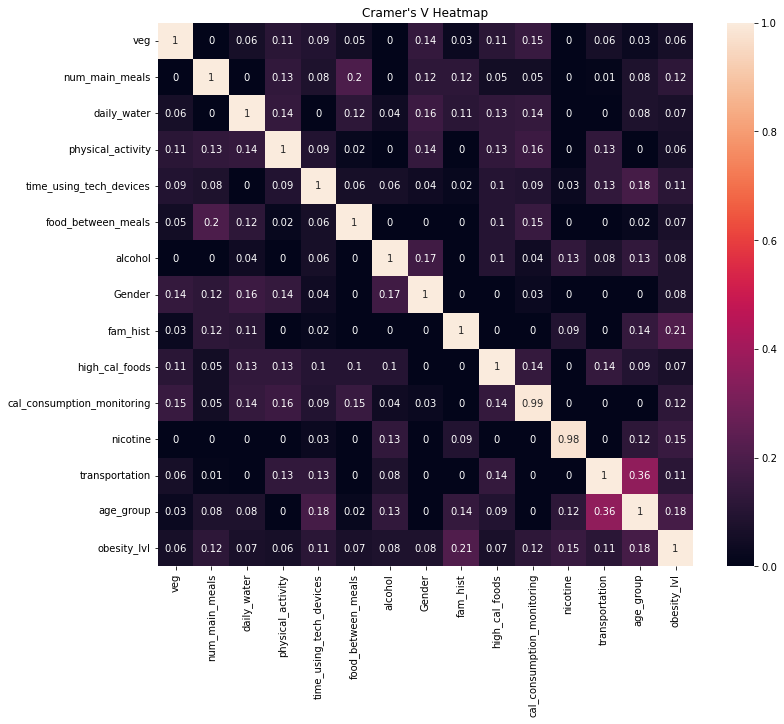

In [27]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cramersV_df[cols], annot=True)
ax.set_title("Cramer's V Heatmap");

Cramer's V doesn't show much correlation between the categorical variables except **age_group** and **transportation** (r=0.36). 

Others worth noting are:
- **fam_hist** and **obesity_lvl** (r=0.21).
- **num_main_meals** and **food_between_meals** (r=0.2).

We can use Random Forest to get feature importances. First, we should convert the categorical variables to numerical values.


In [28]:
for col in set(col4)-set(['Gender', 'transportation']):
    df[col]=df[col].map({'no':0., 'yes':1.})

df['Gender']=df['Gender'].map({'Female':0., 'Male':1.})
df['transportation']=df['transportation'].map({'Automobile':0., 'Public_Transportation':1., 'Walking':2.})
df['obesity_lvl']=df['obesity_lvl'].map({'Underweight':0., 'Normal_Weight':1., 'Overweight_Level_I':2., 'Overweight_Level_II':2., 'Obesity_Type_I':3., 'Obesity_Type_II':3., 'Obesity_Type_III':3.})

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

In [30]:
def forest(indep, dep, kind='built-in'):
    X=df[indep]
    y=df[[dep]]
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=16)
    rf=RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train.values.ravel())
    if kind=='built-in':
        i=rf.feature_importances_.argsort()
        plt.barh(np.array(indep)[i], rf.feature_importances_[i])
        plt.title('Random Forest Built-in Feature Importances')
    elif kind=='perm':
        perm_importance=permutation_importance(rf, X_test, y_test)
        i=perm_importance.importances_mean.argsort()
        plt.barh(np.array(indep)[i], perm_importance.importances_mean[i])
        plt.title('Permutation Based Feature Importances')
    elif kind=='shap':
        explainer=shap.TreeExplainer(rf)
        shap_values=explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test, plot_type='bar')
        shap.summary_plot(shap_values, X_test)

Because BMI is a function of weight and height by definition, we can exclude them.

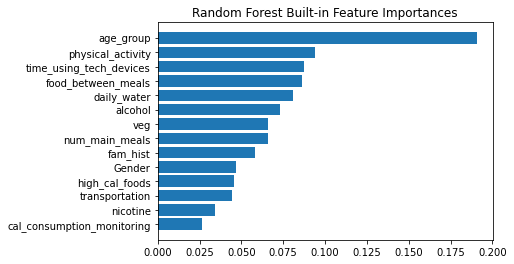

In [31]:
cols=['age_group']+col2+col3+col4
forest(indep=cols, dep='obesity_lvl') 

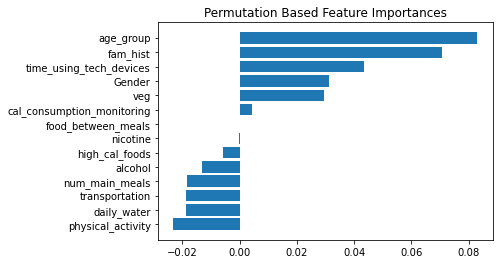

In [32]:
forest(indep=cols, dep='obesity_lvl', kind='perm')

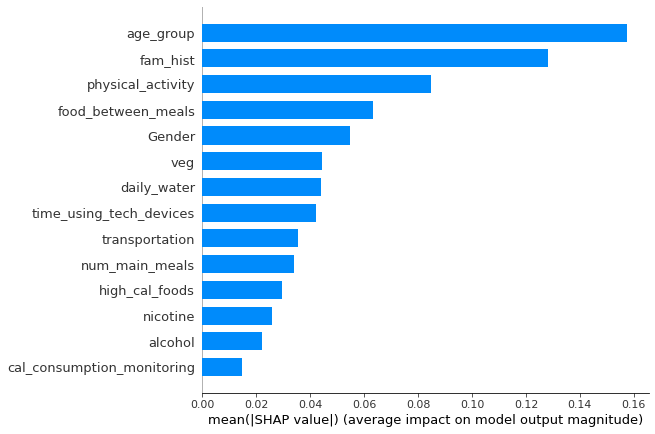

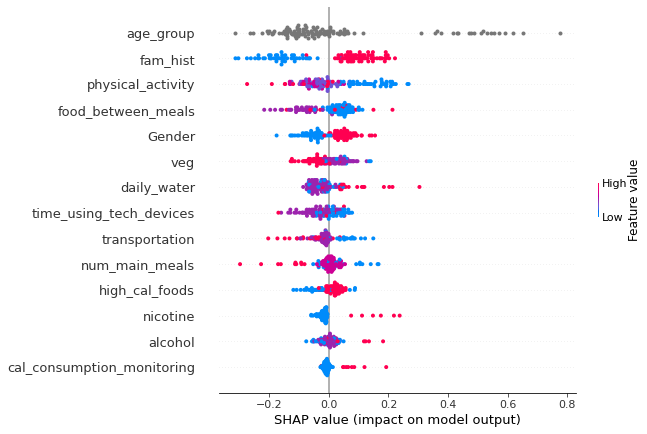

In [33]:
forest(indep=cols, dep='obesity_lvl', kind='shap')

**age_group** seems to have the biggest influence on obesity, but the second important feature changes everytime the computations are rerun. According to all tests, **age**, **fam_hist**, **time_using_tech_devices**, **gender**, **physical_activity** and **daily_water**, **nicotine**, and **food_between_meals** seem to be features worth investigating. 